<h2>Assignment 1 – Problem 2: Michell Structures</h2><br>
Will Langford<br>
Computation Structural Design and Optimization<br>
10/02/16

<h3>Handle imports and setup plotting...</h3>

In [1]:
import numpy as np
from scipy import integrate 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import fsolve
import scipy.spatial.distance as dist
import math

from frame3dd import Frame, NodeData, ReactionData, ElementData, Options, \
    StaticLoadCase
    
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib notebook
# %matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# %config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

/Users/Will/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<h3>Michell Structure Geometry</h3>

I approach generating the Michell structure by repeating a series of steps <b><i>up</i></b> and <b><i>across</i></b>. Because the structure is symetric about the X-axis, these steps are only performed to solve for points in the Y+ coordinate region.

The first step is different from all of the subsequent ones since they all originate from the same support node.

The lengths of the links are found using trigonometric relationships including the law of cosines and the law of sines. Once the length of a given member is determined, its endpoint can be appended to an array by taking into account the angle of the truss element with respect to the x-axis.

I decided to parameterize the structure based on the number of baseline points (points that touch the baseline). For example, a structure with 1 baseline-point (blp) has 2 beam elements, 2 blp --> 8 beam elements, 3 blp --> 18 beam elements, etc...

Once all of the points are solved for, they need to be ordered and connected to correctly represent the beams between the points. These ordered points are represented in two arrays: one for the nodes at the start of each beam element and one for the nodes at the end of each beam element. 

(16, 2)

Michell Truss Joint Locations:
[[  0.           8.        ]
 [ 10.14795162   0.        ]
 [ 12.06858169   2.43630763]
 [ 13.40430605   5.33371775]
 [ 14.04442379   8.55180691]
 [ 13.91194667  11.92357475]
 [ 15.15902319   0.        ]
 [ 17.77525989   3.31868043]
 [ 19.67174014   7.4324641 ]
 [ 20.61748329  12.187036  ]
 [ 21.98498595   0.        ]
 [ 25.62620289   4.61886167]
 [ 28.3174066   10.45653379]
 [ 31.485201     0.        ]
 [ 36.58973316   6.47506819]
 [ 44.803318     0.        ]]

Point Connectivity:
[ 0  0  0  0  0  1  2  3  4  2  3  4  5  6  7  8  7  8  9 10 11 11 12 13 14]
[ 1  2  3  4  5  2  3  4  5  6  7  8  9  7  8  9 10 11 12 11 12 13 14 14 15]


<IPython.core.display.Javascript object>


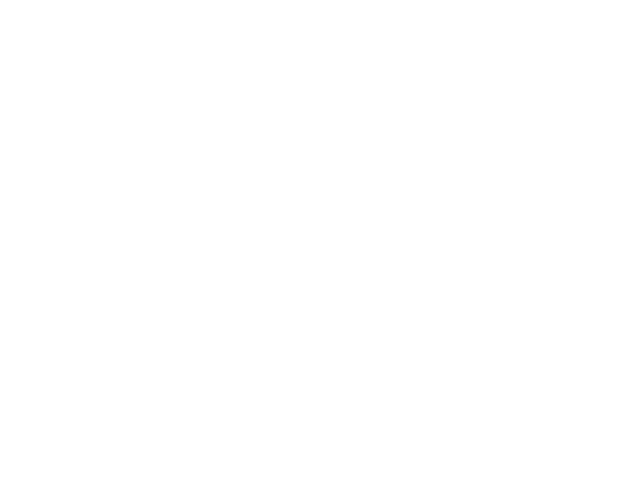

In [2]:
n = 25
h = 16 # the spacing between the supports
gamma = (np.pi/2.)*0.85 # the parameteric angle
p = [] # a list of the points
p.append([0,h/2.]) # the first support point
l = np.zeros([n,n])

# number of baseline points
# blp  n (# of beam elements)
#  1   2
#  2   8
#  3   18
#  4   32
#  5   50
blp = 5

# First step (across)
l[0,0] = h/2./np.tan(gamma/2.)
l[0,1] = np.sqrt((h/2.)**2+(l[0,0])**2)
p.append([l[0,0],0])

# Second step (up)
psi = np.pi/2.-gamma/2.
for n in range(blp-1):
    l[1,n] = np.tan(np.pi/2.-gamma)*l[0,n+1]
    l[0,n+2] = np.sqrt((l[1,n])**2+(l[0,n+1])**2)
    dx = np.cos(psi)*l[1,n]
    dy = np.sin(psi)*l[1,n]
    p.append([p[-1][0]+dx,p[-1][1]+dy])
    psi = np.pi-(np.pi/2.-psi)-gamma

baseline = l[0,0]
index = 0
while (blp-(2+index)) >= 0:
    k = 2*index
    
    # STEP ACROSS
    # print("across "+str(k+2))
    l[2+k,0] = l[1+k,0]/np.cos(np.pi/2.-gamma/2.)
    baseline = baseline + l[2+k,0]
    p.append([baseline,0])

    # STEPS UP
    phi = np.pi-gamma #angle between l[2,1] and l[1,1]
    psi = np.pi/2.-gamma/2.
    l[2+k,1] = np.sqrt(l[2+k,0]**2 + l[1+k,0]**2 - 2*l[2+k,0]*l[1+k,0]*np.cos(psi))
    for n in range(blp-(2+int(k/2))):
        # STEP UP
        # print("  up step " +str(n))
        # after the first step have a quadrilateral (rather than a triangle)
        # and so we need to divide into two triangles and use law of cosines
        # lspan is the distance from the end of l[0,3] to the end of l[2,1]
        lspan = np.sqrt(l[2+k,n+1]**2 + l[1+k,n+1]**2 -2*l[2+k,n+1]*l[1,n+1]*np.cos(phi))
        phi1 = np.arcsin(l[1+k,n+1]/lspan*np.sin(phi)) #angle between l[3,0] and l[2,1]
        phi2 = np.pi-phi-phi1 #angle between l[1,1] and l[2,2]
        alpha1 = np.pi/2. - phi1 #angle between lspan and l[2,2]
        alpha2 = np.pi/2. - phi2 #angle between lspan and l[3,0]
        l[3+k,n] = np.sin(alpha2)/np.sin(gamma)*lspan
        l[2+k,n+2] = np.sin(alpha1)/np.sin(gamma)*lspan
        dx = np.cos(psi)*l[3+k,n]
        dy = np.sin(psi)*l[3+k,n]
        p.append([p[-1][0]+dx,p[-1][1]+dy])
        psi = np.pi-(np.pi/2.-psi)-gamma
    index = index+1

print(np.shape(p))
print()
print("Michell Truss Joint Locations:")
print(np.array(p))

# ORDER AND CONNECT THE POINTS
N1 = np.zeros(80,dtype=np.int8) # start nodes
N2 = np.zeros(80,dtype=np.int8) # end nodes

index = 0
for i in range(blp):
    N1[i] = 0
    N2[i] = i+1
    index = index+1
for j in reversed(range(1,blp)):
    start_index = index
    for i in range(j):
        N1[index] = N1[index-1]+1
        N2[index] = N1[index-1]+2
        index = index+1
    for i in range(j):
        N1[index] = N1[start_index]+1*(i+1)
        N2[index] = N2[index-1]+1
        index = index+1

# trim trailing zeros
N2 = np.trim_zeros(N2,'b')
N1 = N1[0:len(N2)]

print()
print("Point Connectivity:")
print(N1)
print(N2)

# PLOT TRUSS STRUCTURE
plt.close('all')
p = np.array(p)
fig = plt.figure()
ax = fig.add_subplot(111)

# plot topside
ax.plot(p[:,0], p[:,1],'bo') # joint locations
ax.plot([p[N1,0],p[N2,0]],[p[N1,1],p[N2,1]],'k') # beam elements
# plot bottomside
ax.plot(p[:,0], -p[:,1],'bo') # joint locations
ax.plot([p[N1,0],p[N2,0]],[-p[N1,1],-p[N2,1]],'k') # beam elements

plt.axes().set_aspect('equal', 'datalim')
fig

Now that this is all working nicely, we'd like to make the geometry generation parametric and reusable.

Here, I copy that work and wrap it in a function.
<ul>
<h4>The function takes arguments:</h4>
<ul>
<li><b>blp</b>, the number of baseline points
<li><b>h</b>, the vertical spacing of the support nodes
<li>and <b>alpha</b>, a normalized representation of gamma between between 0 and 1
</ul>
<h4>and returns:</h4>
<ul>
<li><b>p</b>, an array of all of the points in the Y+ region
<li><b>N1</b>, the ordered list of the start nodes of the beam elements
<li><b>N2</b>, the ordered list of the end nodes of the beam elements
<li>and <b>gamma</b>, the angle used to determine the structure.
</ul>
<ul>

In [3]:
def generate_truss_points(blp,h,alpha):
    # blp is the number of baseline points
    # where h is the distance between supports
    # and alpha is a value from 0 to 1 and is the ratio of gamma to 90-degrees
    n = 25
    gamma = (np.pi/2.)*alpha # the parameteric angle
    p = [] # a list of the points
    p.append([0,h/2.]) # the first support point
    l = np.zeros([n,n])

    # number of baseline points
    # blp  n (# of beam elements)
    #  1   2
    #  2   8
    #  3   18
    #  4   32
    #  5   50

    # First step (across)
    l[0,0] = h/2./np.tan(gamma/2.)
    l[0,1] = np.sqrt((h/2.)**2+(l[0,0])**2)
    p.append([l[0,0],0])

    # Second step (up)
    psi = np.pi/2.-gamma/2.
    for n in range(blp-1):
        l[1,n] = np.tan(np.pi/2.-gamma)*l[0,n+1]
        l[0,n+2] = np.sqrt((l[1,n])**2+(l[0,n+1])**2)
        dx = np.cos(psi)*l[1,n]
        dy = np.sin(psi)*l[1,n]
        p.append([p[-1][0]+dx,p[-1][1]+dy])
        psi = np.pi-(np.pi/2.-psi)-gamma

    baseline = l[0,0]
    index = 0
    while (blp-(2+index)) >= 0:
        k = 2*index

        # STEP ACROSS
        # print("across "+str(k+2))
        l[2+k,0] = l[1+k,0]/np.cos(np.pi/2.-gamma/2.)
        baseline = baseline + l[2+k,0]
        p.append([baseline,0])

        # STEPS UP
        phi = np.pi-gamma #angle between l[2,1] and l[1,1]
        psi = np.pi/2.-gamma/2.
        l[2+k,1] = np.sqrt(l[2+k,0]**2 + l[1+k,0]**2 - 2*l[2+k,0]*l[1+k,0]*np.cos(psi))
        for n in range(blp-(2+int(k/2))):
            # STEP UP
            # print("  up step " +str(n))
            # after the first step have a quadrilateral (rather than a triangle)
            # and so we need to divide into two triangles and use law of cosines
            # lspan is the distance from the end of l[0,3] to the end of l[2,1]
            lspan = np.sqrt(l[2+k,n+1]**2 + l[1+k,n+1]**2 -2*l[2+k,n+1]*l[1,n+1]*np.cos(phi))
            phi1 = np.arcsin(l[1+k,n+1]/lspan*np.sin(phi)) #angle between l[3,0] and l[2,1]
            phi2 = np.pi-phi-phi1 #angle between l[1,1] and l[2,2]
            alpha1 = np.pi/2. - phi1 #angle between lspan and l[2,2]
            alpha2 = np.pi/2. - phi2 #angle between lspan and l[3,0]
            l[3+k,n] = np.sin(alpha2)/np.sin(gamma)*lspan
            l[2+k,n+2] = np.sin(alpha1)/np.sin(gamma)*lspan
            dx = np.cos(psi)*l[3+k,n]
            dy = np.sin(psi)*l[3+k,n]
            p.append([p[-1][0]+dx,p[-1][1]+dy])
            psi = np.pi-(np.pi/2.-psi)-gamma
        index = index+1
        
    # ORDER AND CONNECT THE POINTS
    N1 = np.zeros(80,dtype=np.int8) # start nodes
    N2 = np.zeros(80,dtype=np.int8) # end nodes

    index = 0
    for i in range(blp):
        N1[i] = 0
        N2[i] = i+1
        index = index+1
    for j in reversed(range(1,blp)):
        start_index = index
        for i in range(j):
            N1[index] = N1[index-1]+1
            N2[index] = N1[index-1]+2
            index = index+1
        for i in range(j):
            N1[index] = N1[start_index]+1*(i+1)
            N2[index] = N2[index-1]+1
            index = index+1
    # trim trailing zeros
    N2 = np.trim_zeros(N2,'b')
    N1 = N1[0:len(N2)]
    
    return [np.array(p), N1, N2, gamma]

To plot the truss, we make a function that takes the points and the ordered lists of start and end nodes and returns the plotted result.

In [4]:
def plot_truss(p,N1,N2,ax,label=''):
    # PLOT TRUSS STRUCTURE

    # plot topside
    ax.plot(p[:,0], p[:,1],'bo') # joint locations
    ax.plot([p[N1,0],p[N2,0]],[p[N1,1],p[N2,1]],'k') # beam elements

    # plot bottomside
    ax.plot(p[:,0], -p[:,1],'bo') # joint locations
    ax.plot([p[N1,0],p[N2,0]],[-p[N1,1],-p[N2,1]],'k') # beam elements
    
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim([-10,50])
    ax.set_ylabel(label)
    ax.set_yticks([])

    return fig

def clear_axis(ax):
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_frame_on(False)

<IPython.core.display.Javascript object>


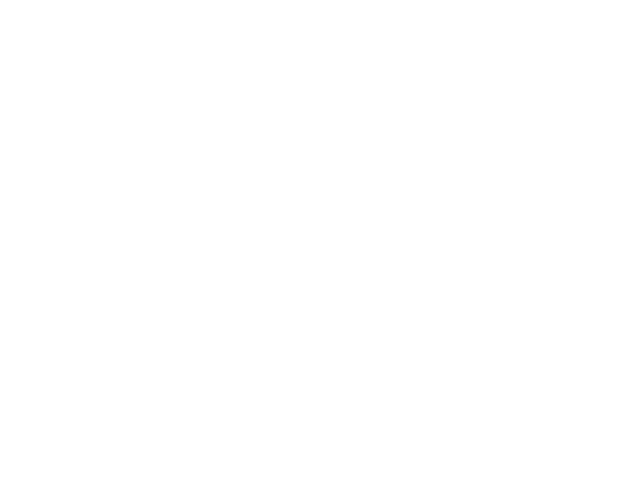

In [5]:
[points, start_points, end_points, gam] = generate_truss_points(3,16,0.8)
fig = plt.figure()
ax = fig.add_subplot(111)
plot_truss(points,start_points,end_points,ax)

<h3>Searching for a structure of a given length</h3>

Since the structure is naturally parameterized by gamma and H (but not L), we need to search for a gamma that gives us the right L.

To do this, I created a function <b>residual</b> which takes gamma, blp, h, and a desired length. It generates a structure given those parameters and then returns the square of difference between the desired length and the actual length.

We can then use optimization techniques to minimize this residual by varying gamma. The function will reach a minimum when the actual length is equal to the desired length. In this case, I use a nelder-mead simplex algorithm implemented through SciPY's minimize function. This is a relatively simple (but effective algorithm) that works well for this problem since it doesn't require the evaluation of a deriviate of the function.

In [6]:
from scipy.optimize import minimize

def residual(x,blp,h,length):
    [points, start_points, end_points, gam] = generate_truss_points(blp,h,x)
    return (length-points[-1][0])**2

def find_truss_points(blp,h,length):
    res = minimize(residual, 0.8, args=(blp,h,length), method='nelder-mead',
               options={'xtol': 1e-8, 'disp': False})
    [points, start_points, end_points, gam] = generate_truss_points(blp,h,res.x)
    return [points, start_points, end_points, gam]

def find_truss(blp,h,length,figure,label):
    res = minimize(residual, 0.8, args=(blp,h,length), method='nelder-mead',
               options={'xtol': 1e-8, 'disp': False})
    [points, start_points, end_points, gam] = generate_truss_points(blp,h,res.x)
    return plot_truss(points,start_points,end_points,
                      figure,label+", $\gamma=$"+str(np.round(gam[0]*180/np.pi,1)))

Using this function, we can now generate the geometry of a structure in terms of H, L, and the number of baseline points.

<IPython.core.display.Javascript object>


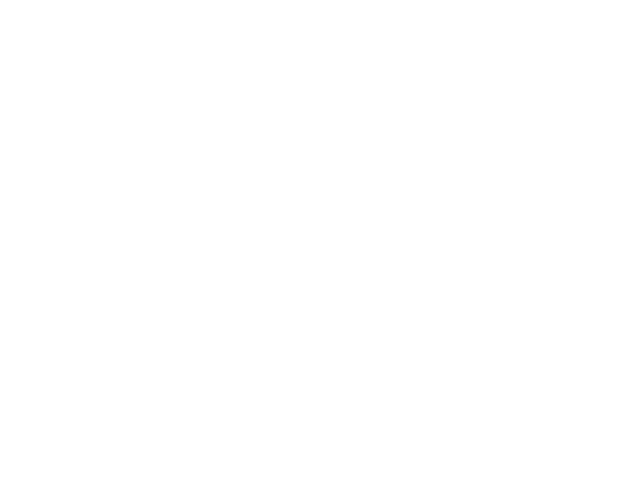

In [7]:
h = 16
plt.close('all')
# Six axes, returned as a 2-d array
f, axarr = plt.subplots(3, 2)
find_truss(1,h,40,axarr[0, 0],'n=2')
find_truss(2,h,40,axarr[0, 1],'n=8')
find_truss(3,h,40,axarr[1, 0],'n=18')
find_truss(4,h,40,axarr[1, 1],'n=32')
find_truss(5,h,40,axarr[2, 0],'n=50')
clear_axis(axarr[2,1])
plt.suptitle('H = ' + str(h) + 'ft')
f

<IPython.core.display.Javascript object>


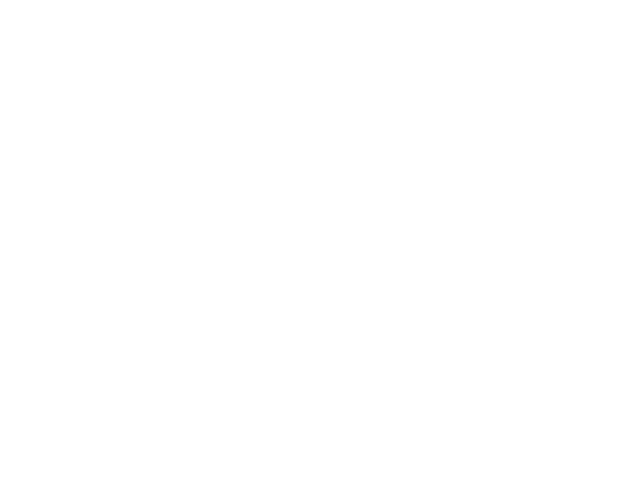

In [8]:
h = 8
plt.close('all')
# Six axes, returned as a 2-d array
f, axarr = plt.subplots(3, 2)
find_truss(1,h,40,axarr[0, 0],'n=2')
find_truss(2,h,40,axarr[0, 1],'n=8')
find_truss(3,h,40,axarr[1, 0],'n=18')
find_truss(4,h,40,axarr[1, 1],'n=32')
find_truss(5,h,40,axarr[2, 0],'n=50')
clear_axis(axarr[2,1])
plt.suptitle('H = ' + str(h) + 'ft')
f

<IPython.core.display.Javascript object>


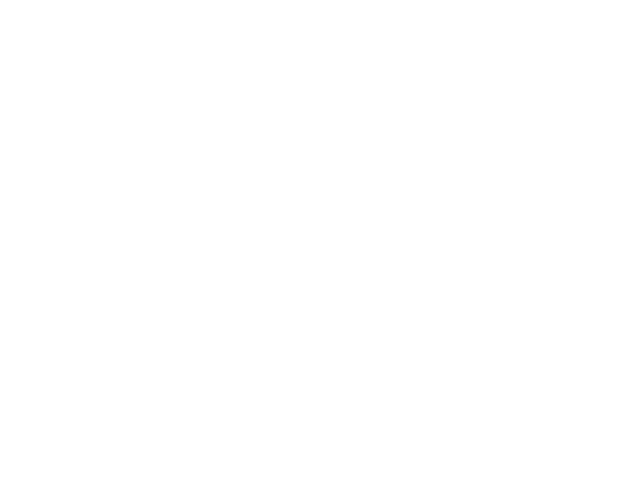

In [9]:
h = 4
plt.close('all')
# Six axes, returned as a 2-d array
f, axarr = plt.subplots(3, 2)
find_truss(1,h,40,axarr[0, 0],'n=2')
find_truss(2,h,40,axarr[0, 1],'n=8')
find_truss(3,h,40,axarr[1, 0],'n=18')
find_truss(4,h,40,axarr[1, 1],'n=32')
find_truss(5,h,40,axarr[2, 0],'n=50')
clear_axis(axarr[2,1])
plt.suptitle('H = ' + str(h) + 'ft')
plt.show()

<h3>Loading the Structure</h3>

To apply loads to the structure, I will use a structural analysis tool called Frame3DD for which there are python bindings: <a href="https://github.com/WISDEM/pyFrame3DD">pyFrame3DD</a>.

The first step in simulating loads in this structure is to reformat the connectivity of the nodes to ensure there are no duplicates. This is necessary because I used symmetry above to only solve for the upper half of the structure and created the lower half by reflecting the upper half about the X-axis. This has the side-effect of doubling up the baseline points and would result in a structure which is not well connected.

To fix this, I need to iterate through the list of start and end nodes in the lower half of the structure and strip out the ones where the Y coordinate is 0.

In [10]:
[p, N1, N2, gam] = find_truss_points(5,16,40)
tophalf = p
bottomhalf = np.array([p[:,0],-p[:,1]]).T
bottomhalf2 = bottomhalf[np.nonzero(bottomhalf[:,1])]
p = np.vstack((tophalf,bottomhalf2))
    
def reformat_connectivity(N,zeros,inc):
    output = np.copy(N)
    for i in range(len(N)):
        if (len(np.argwhere(zeros == N[i]))):
            output[i] = np.copy(N[i])
            output[i+1:] = output[i+1:] - 1
        else:
            output[i] = output[i]+inc
    return output

zeros = np.ravel(np.argwhere(bottomhalf[:,1]==0))

bottom_N1 = reformat_connectivity(N1,zeros,N2[-1]+1)
bottom_N2 = reformat_connectivity(N2,zeros,N2[-1]+1)

N1 = np.hstack((N1, bottom_N1))
N2 = np.hstack((N2, bottom_N2))

print(N1)
print(N2)

[ 0  0  0  0  0  1  2  3  4  2  3  4  5  6  7  8  7  8  9 10 11 11 12 13 14
 16 16 16 16 16  1 17 18 19 17 18 19 20  6 21 22 21 22 23 10 24 24 25 13 26]
[ 1  2  3  4  5  2  3  4  5  6  7  8  9  7  8  9 10 11 12 11 12 13 14 14 15
  1 17 18 19 20 17 18 19 20  6 21 22 23 21 22 23 10 24 25 24 25 13 26 26 15]


We can then import our geometry into a format that frame3dd expects: nodes, reaction nodes, and elements.

We then apply a point load to the last node in the negative Z direction*.

*Frame3DD seems to expect loading to be applied primarily in the Z-axis so the structure had to be rotated from the XY plane to the XZ plane. 

In [11]:
node = np.arange(1,len(p[:,0])+1)
x = p[:,0]*100
y = np.zeros(len(p[:,0]))
z = p[:,1]*100
r = np.zeros(len(p[:,0]))
nodes = NodeData(node, x, y, z, r)

# ------ reaction data ------------
node = np.array([1, 1+bottom_N1[0]])
Rx = np.ones(2)
Ry = np.ones(2)
Rz = np.ones(2)
Rxx = np.ones(2)
Ryy = np.ones(2)
Rzz = np.ones(2)
reactions = ReactionData(node, Rx, Ry, Rz, Rxx, Ryy, Rzz, rigid=1)

# ------ frame element data ------------
element = np.arange(1,len(N1)+1)
N1a = N1+1
N2a = N2+1
Ax = 36.0*np.ones(len(element))
Asy = 20.0*np.ones(len(element))
Asz = 20.0*np.ones(len(element))
Jx = 1000.0*np.ones(len(element))
Iy = 492.0*np.ones(len(element))
Iz = 492.0*np.ones(len(element))
E = 200000.0*np.ones(len(element))
G = 79300.0*np.ones(len(element))
roll = np.zeros(len(element))
density = 7.85e-9*np.ones(len(element))
elements = ElementData(element, N1a, N2a, Ax, Asy, Asz, 
                       Jx, Iy, Iz, E, G, roll, density)

# ------ other data ------------
shear = 1               # 1: include shear deformation
geom = 1                # 1: include geometric stiffness
dx = 10.0               # x-axis increment for internal forces
other = Options(shear, geom, dx)

# initialize frame3dd object
frame = Frame(nodes, reactions, elements, other)

# gravity in the X, Y, Z, directions (global)
gx = 0.0
gy = 0.0
gz = 0.0#-9806.33
load = StaticLoadCase(gx, gy, gz)

# point load
nF = np.array([N2[-1]+1])
Fx = np.array([0.0])
Fy = np.array([0.0])
Fz = np.array([-1.0])
Mxx = np.array([0.0])
Myy = np.array([0.0])
Mzz = np.array([0.0])
load.changePointLoads(nF, Fx, Fy, Fz, Mxx, Myy, Mzz)
frame.addLoadCase(load)

# run the analysis
displacements, forces, reactions, internalForces, mass, modal = frame.run()
displacements.dyrot

array([[  0.00000000e+00,   9.87148643e-08,   1.04032001e-07,
          1.00163563e-07,   2.90229869e-07,   4.48549195e-07,
          1.13474625e-07,   1.16893031e-07,   2.54796359e-07,
          3.66079686e-07,   1.12998313e-07,   2.51003758e-07,
          3.66790517e-07,   3.65376989e-07,   5.30774251e-07,
          8.12313159e-07,   0.00000000e+00,   1.04032161e-07,
          1.00163980e-07,   2.90226905e-07,   4.48603432e-07,
          1.16893233e-07,   2.54798638e-07,   3.66081910e-07,
          2.51004269e-07,   3.66803985e-07,   5.30773022e-07]])

Now that we can solve for displacements, forces, and reactions in the structure, let's wrap that capability in a function:

In [12]:
def reformat_connectivity(N,zeros,inc):
    output = np.copy(N)
    for i in range(len(N)):
        if (len(np.argwhere(zeros == N[i]))):
            output[i] = np.copy(N[i])
            output[i+1:] = output[i+1:] - 1
        else:
            output[i] = output[i]+inc
    return output

def setup_frame3dd_simulation(blp,height,leng,xscale=1.0,yscale=1.0):
    # format point array and node ordering
    [p, N1, N2, gam] = find_truss_points(blp,height,leng)
    p[:,0] = xscale*p[:,0]
    p[:,1] = yscale*p[:,1]
    tophalf = p
    bottomhalf = np.array([p[:,0],-p[:,1]]).T
    bottomhalf2 = bottomhalf[np.nonzero(bottomhalf[:,1])]
    p = np.vstack((tophalf,bottomhalf2))

    zeros = np.ravel(np.argwhere(bottomhalf[:,1]==0))

    bottom_N1 = reformat_connectivity(N1,zeros,N2[-1]+1)
    bottom_N2 = reformat_connectivity(N2,zeros,N2[-1]+1)

    N1 = np.hstack((N1, bottom_N1))
    N2 = np.hstack((N2, bottom_N2))

    # ------ Node data -----------
    node = np.arange(1,len(p[:,0])+1)
    x = p[:,0]*100
    y = np.zeros(len(p[:,0]))
    z = p[:,1]*100
    r = np.zeros(len(p[:,0]))
    nodes = NodeData(node, x, y, z, r)

    # ------ reaction data ------------
    node = np.array([1, 1+bottom_N1[0]])
    Rx = np.ones(2)
    Ry = np.ones(2)
    Rz = np.ones(2)
    Rxx = np.ones(2)
    Ryy = np.ones(2)
    Rzz = np.ones(2)
    reactions = ReactionData(node, Rx, Ry, Rz, Rxx, Ryy, Rzz, rigid=1)

    # ------ frame element data ------------
    element = np.arange(1,len(N1)+1)
    N1a = N1+1
    N2a = N2+1
    Ax = 36.0*np.ones(len(element))
    Asy = 20.0*np.ones(len(element))
    Asz = 20.0*np.ones(len(element))
    Jx = 1000.0*np.ones(len(element))
    Iy = 492.0*np.ones(len(element))
    Iz = 492.0*np.ones(len(element))
    E = 200000.0*np.ones(len(element))
    G = 79300.0*np.ones(len(element))
    roll = np.zeros(len(element))
    density = 7.85e-9*np.ones(len(element))
    elements = ElementData(element, N1a, N2a, Ax, Asy, 
                           Asz, Jx, Iy, Iz, E, G, roll, density)

    # ------ other data ------------
    shear = 1               # 1: include shear deformation
    geom = 1                # 1: include geometric stiffness
    dx = 10.0               # x-axis increment for internal forces
    other = Options(shear, geom, dx)

    # initialize frame3dd object
    frame = Frame(nodes, reactions, elements, other)

    # gravity in the X, Y, Z, directions (global)
    gx = 0.0
    gy = 0.0
    gz = 0.0#-9806.33
    load = StaticLoadCase(gx, gy, gz)

    # point load
    nF = np.array([N2[-1]+1])
    Fx = np.array([0.0])
    Fy = np.array([0.0])
    Fz = np.array([-1.0])
    Mxx = np.array([0.0])
    Myy = np.array([0.0])
    Mzz = np.array([0.0])
    load.changePointLoads(nF, Fx, Fy, Fz, Mxx, Myy, Mzz)
    frame.addLoadCase(load)
    return [frame, p, N1, N2]
   

Then we can create a function to run the simulation and evaluate the performance of the truss by multiplying the axial force in each member by its length. This gives a measure of performance that is proportional to its volume.

In [13]:
def simulate_truss(frame):
    # run the analysis
    displacements, forces, reactions, internalForces, mass, modal = frame.run()
    return forces.Nx.T

def simulate_truss_disp(frame):
    # run the analysis
    displacements, forces, reactions, internalForces, mass, modal = frame.run()
    return [forces.Nx.T, displacements]

def calculate_metric(forces, p, N1, N2):
    axial_force = np.abs(forces[np.arange(0,len(forces),2)])
    l = np.zeros(len(N1))
    for i in range(len(N1)):
        l[i] = dist.euclidean(p[N1[i],:],p[N2[i],:])
    return [np.sum(l*axial_force.T), axial_force]

To visualize the forces in the struts, we can map color to the axial force values and increase the stroke width where there is more force.

In [14]:
def norm(arr):
#     return (arr - np.min(arr)) / float(np.max(arr) - np.min(arr))
    return (arr) / float(np.max(arr))

def plot_truss_forces(p,N1,N2,ax,forces):
    # PLOT TRUSS STRUCTURE WITH FORCES

    # assumes unified p array (both tophalf and bottomhalf)
    ax.plot(p[:,0], p[:,1],'bo',MarkerSize=4) # joint location
    
    colors = plt.cm.rainbow(norm(forces))
    for i in range(len(N1)):
        ax.plot([p[N1[i],0],p[N2[i],0]],[p[N1[i],1],p[N2[i],1]],
                c=np.ravel(colors[i]),lw=norm(forces)[i]*4+0.5) # beam elements
    
    ax.set_aspect('equal', 'datalim')
#     ax.set_xlim([-10,90])
    ax.set_xlim([-10,50])
    ax.set_yticks([])

    return fig

def plot_truss_forces_alpha(p,N1,N2,ax,forces):
    # PLOT TRUSS STRUCTURE WITH FORCES
    
#     ax.plot(p[:,0], p[:,1],'ko',alpha=0.25) # joint location
    
    colors = plt.cm.bone(1-norm(forces))
    for i in range(len(N1)):
        ax.plot([p[N1[i],0],p[N2[i],0]],[p[N1[i],1],p[N2[i],1]],
                c=np.ravel(colors[i]),lw=norm(forces)[i]*4+0.5,
               alpha=0.25) # beam elements
    
    ax.set_aspect('equal', 'datalim')
#     ax.set_xlim([-10,90])
    ax.set_xlim([-10,50])
    ax.set_yticks([])

    return fig

These plotting tools are helpful for visualizing how the forces are distributed in the structures.

By plotting three structures with varying values of H, it's clear that the forces move through the structures in different ways.

When H=16ft, the most loaded members are on the extremeties of the structure, meaning that more length is being effectively utilized for its load bearing capability.

On the other hand, when H=4ft, the most loaded members are the ones that are left-most and inner-most. These members are also the shortest members of the structure and so the structure is not utilizing the longer members well.

<IPython.core.display.Javascript object>


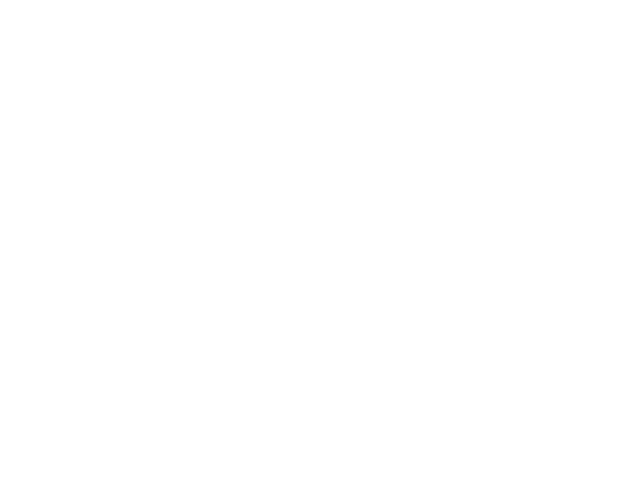

In [15]:
plt.close('all')
f, axarr = plt.subplots(3, 1)

[f, p, N1, N2] = setup_frame3dd_simulation(5,4,40,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[0],ax_f)
axarr[0].set_ylabel('H=4ft')

[f, p, N1, N2] = setup_frame3dd_simulation(5,8,40,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[1],ax_f)
axarr[1].set_ylabel('H=8ft')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[2],ax_f)
axarr[2].set_ylabel('H=16ft')

plt.suptitle('N = ' + str(50))
plt.show()

Using interactive widgets, we can interactively generate the structure and visualize the deformation...

5.05


<IPython.core.display.Javascript object>


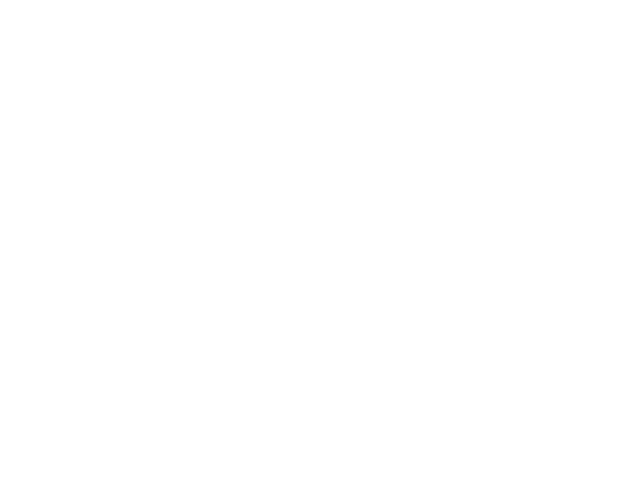

<function __main__.interactive_plot>

In [16]:
def plot_truss_displacements(p,N1,N2,ax,forces,d,scale=1.0):
    # PLOT TRUSS STRUCTURE WITH FORCES
    print(scale)
    
    p_disp = np.copy(p)
    p_disp[:,0] = p[:,0] + d.dx*np.exp(scale)
    p_disp[:,1] = p[:,1] + d.dz*np.exp(scale)
    
    # assumes unified p array (both tophalf and bottomhalf)
    ax.plot(p_disp[:,0], p_disp[:,1],'bo',MarkerSize=4) # joint location
    
    colors = plt.cm.gray(1-norm(forces)-0.25)
    for i in range(len(N1)):
        ax.plot([p[N1[i],0],p[N2[i],0]],[p[N1[i],1],p[N2[i],1]],
                c=np.ravel(colors[i]),lw=norm(forces)[i]*4+0.5,
               alpha=0.5) # beam elements
    
    colors = plt.cm.rainbow(norm(forces))
    for i in range(len(N1)):
        ax.plot([p_disp[N1[i],0],p_disp[N2[i],0]],[p_disp[N1[i],1],p_disp[N2[i],1]],
                c=np.ravel(colors[i]),lw=norm(forces)[i]*6+0.5) # beam elements
    
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim([-10,50])
    ax.set_yticks([])

    return fig

def interactive_plot(scale,h,n):
    ax = plt.subplot(111)
    [f, pp, n1, n2] = setup_frame3dd_simulation(n,h,40,1.0)
    [forces,d] = simulate_truss_disp(f)
    [pl,axf] = calculate_metric(forces, pp, n1, n2)
    plot_truss_displacements(pp,n1,n2,ax,axf,d,scale)
    plt.show()

plt.close('all')
interact(interactive_plot,scale=(0.1,10),h=(4,16,1),n=(1,8,1))

Now we can do a parametric sweep over a range of heights and lengths and determine the relative performance of the structures.

(Lower values are better for the performance metric)

In [17]:
pls = np.zeros([3,5])
h = 4
print("H = " + str(h) +"ft")
for i in range(5):
    [f, p, N1, N2] = setup_frame3dd_simulation(i+1,h,40)
    forces = simulate_truss(f)
    [pl, ax_f] = calculate_metric(forces, p, N1, N2)
    pls[0,i] = pl
    print("blp = " + str(i+1) + "  sum(p*L) = " + str(pl))
h = 8
print("H = " + str(h) +"ft")
for i in range(5):
    [f, p, N1, N2] = setup_frame3dd_simulation(i+1,h,40)
    forces = simulate_truss(f)
    [pl, ax_f] = calculate_metric(forces, p, N1, N2)
    pls[1,i] = pl
    print("blp = " + str(i+1) + "  sum(p*L) = " + str(pl))
h = 16
print("H = " + str(h) +"ft")
for i in range(5):
    [f, p, N1, N2] = setup_frame3dd_simulation(i+1,h,40)
    forces = simulate_truss(f)
    [pl, ax_f] = calculate_metric(forces, p, N1, N2)
    pls[2,i] = pl
    print("blp = " + str(i+1) + "  sum(p*L) = " + str(pl))

H = 4ft
blp = 1  sum(p*L) = 801.180751519
blp = 2  sum(p*L) = 337.662095055
blp = 3  sum(p*L) = 302.882207921
blp = 4  sum(p*L) = 293.282060302
blp = 5  sum(p*L) = 289.335713065
H = 8ft
blp = 1  sum(p*L) = 403.897555356
blp = 2  sum(p*L) = 241.013982316
blp = 3  sum(p*L) = 226.578694905
blp = 4  sum(p*L) = 222.530073984
blp = 5  sum(p*L) = 220.862037219
H = 16ft
blp = 1  sum(p*L) = 207.987185104
blp = 2  sum(p*L) = 164.461931168
blp = 3  sum(p*L) = 160.194018066
blp = 4  sum(p*L) = 158.98584083
blp = 5  sum(p*L) = 158.485855101


<IPython.core.display.Javascript object>


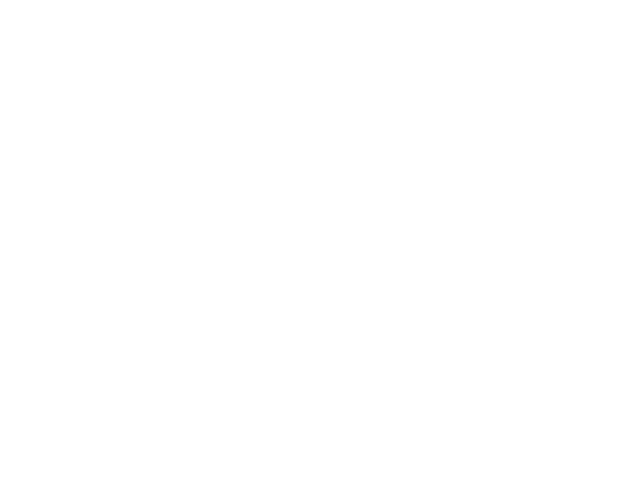

In [18]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = [4,8,16]*np.ones([5,3])
Y = [1,2,3,4,5]*np.ones([3,5])

ax.scatter(X.T,Y,pls,s=norm(pls)*100)
cset = ax.contourf(X.T, Y, pls, zdir='z', offset=100, cmap=plt.cm.coolwarm,extend3d=True)
# ax.plot_surface(X.T,Y,pls,rstride=1, cstride=1,cmap=plt.cm.coolwarm)
ax.set_xlabel('Height (ft)')
ax.set_ylabel('# of Baseline Points')
ax.set_zlabel('Performance Metric')
plt.show()

From the plot, it is clear that optimal performance is achieved with more members in the structure (larger number of baseline points) and with a larger distance between support nodes.

The plots above, which color code the beam elements with their amount of axial loading, demonstrate that by spreading the support nodes apart, longer beam elements are better utilized.

<h3>Stretching and Scaling the Structures</h3>

We can analyze how well these structures perform if they're stretched and scaled from their original dimensions:

<IPython.core.display.Javascript object>


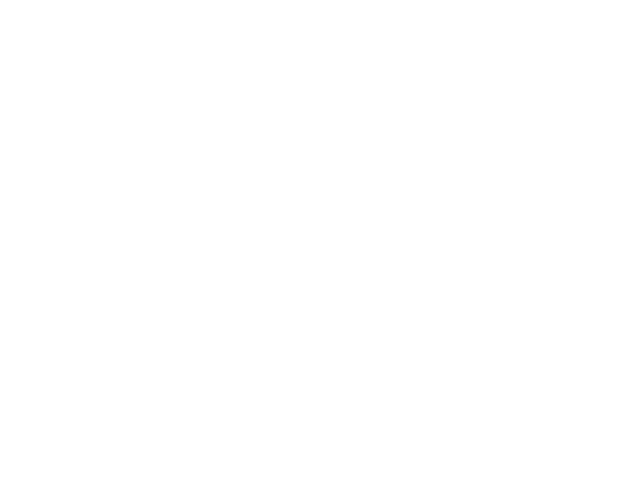

In [19]:
plt.close('all')
f, axarr = plt.subplots(2, 2)

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,0.5)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[0,0],ax_f)
axarr[0,0].set_xlim([-10,30])
axarr[0,0].set_ylabel('x:0.5, y:1.0')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,20,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces_alpha(p,N1,N2,axarr[0,0],ax_f)
axarr[0,0].set_xlim([-10,30])
axarr[0,0].set_ylabel('x:0.5, y:1.0')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,2.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[1,0],ax_f)
axarr[1,0].set_xlim([-10,90])
axarr[1,0].set_ylabel('x:2.0, y:1.0')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,80,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces_alpha(p,N1,N2,axarr[1,0],ax_f)
axarr[1,0].set_xlim([-10,90])
axarr[1,0].set_ylabel('x:2.0, y:1.0')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,1.0,0.5)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[0,1],ax_f)
axarr[0,1].set_xlim([-10,50])
axarr[0,1].set_ylabel('x:1.0, y:0.5')

[f, p, N1, N2] = setup_frame3dd_simulation(5,8,40,1.0,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces_alpha(p,N1,N2,axarr[0,1],ax_f)
axarr[0,1].set_xlim([-10,50])
axarr[0,1].set_ylabel('x:1.0, y:0.5')

[f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,1.0,2.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces(p,N1,N2,axarr[1,1],ax_f)
axarr[1,1].set_xlim([-10,50])
axarr[1,1].set_ylabel('x:1.0, y:2.0')

[f, p, N1, N2] = setup_frame3dd_simulation(5,32,40,1.0,1.0)
forces = simulate_truss(f)
[pl,ax_f] = calculate_metric(forces, p, N1, N2)
plot_truss_forces_alpha(p,N1,N2,axarr[1,1],ax_f)
axarr[1,1].set_xlim([-10,50])
axarr[1,1].set_ylabel('x:1.0, y:2.0')

plt.suptitle('N = ' + str(50))
plt.show()

Let's analyze the performance for an 10x10 array of X-scale and Y-scale values:

In [20]:
# Generate the structures
n_xscale = 10
n_yscale = 10
xscales = np.linspace(0.5,2.0,n_xscale)
yscales = np.linspace(0.5,2.0,n_xscale)
pl3d = np.zeros([n_xscale,n_yscale])
pl3d2 = np.zeros([n_xscale,n_yscale])
for i in range(n_xscale):
    for j in range(n_yscale):
        # Stretching the michell structure
        [f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,xscales[i],yscales[j])
        forces = simulate_truss(f)
        [pl,ax_f] = calculate_metric(forces, p, N1, N2)
        pl3d[i,j] = pl
        # VS
        # Generating a michell structure based on stretched boundary conditions
        [f, p, N1, N2] = setup_frame3dd_simulation(5,16*yscales[j],40*xscales[i],1.0,1.0)
        forces = simulate_truss(f)
        [pl,ax_f] = calculate_metric(forces, p, N1, N2)
        pl3d2[i,j] = pl

<IPython.core.display.Javascript object>


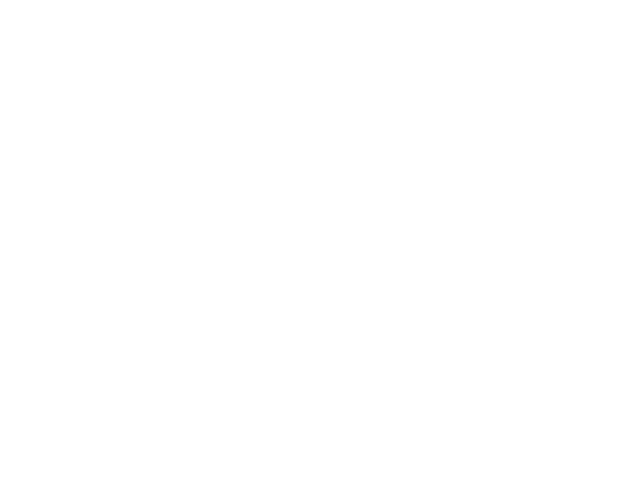

In [21]:
# Plot the results
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xscale3d = xscales*np.ones([n_xscale,n_yscale])
yscale3d = yscales*np.ones([n_yscale,n_xscale])

ax.plot_surface(xscale3d.T,yscale3d,pl3d,rstride=1, cstride=1,
                cmap=plt.cm.coolwarm, alpha=1.0)

ax.set_xlabel('X-Scale')
ax.set_ylabel('Y-Scale')
ax.set_zlabel('Performance Metric')
plt.show()

This plot shows that there is a clear loss in performance for structures scaled in the X-axis (which is to say, stretched to be thinner). From this plot, though, it's unclear whether squishing the structure (making it shorter and fatter) causes a loss in performance.

To get a better sense of the effect scaling has on the performance of these structures, it's helpful to compare them to a true Michell truss generated from stretched/squished boundary conditions. These are shown in gray in the figure of 4 subplots above.

If, instead of plotting the absolute performance metric, we plot the relative difference between the deformed trusses and the ideal ones, then we get a plot like this: 

<IPython.core.display.Javascript object>


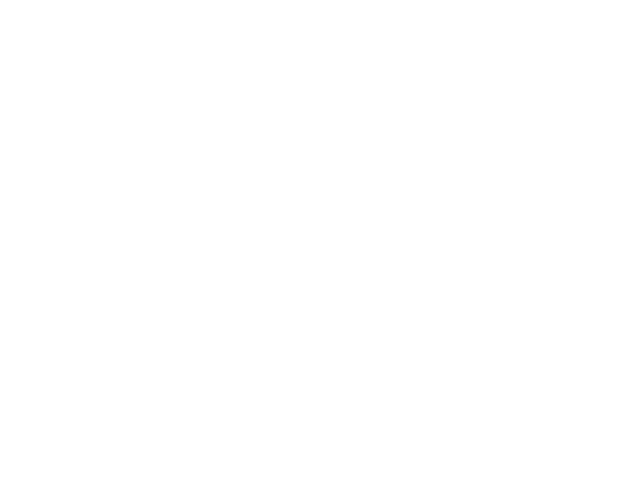

In [22]:
# Plot the results
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xscale3d = xscales*np.ones([n_xscale,n_yscale])
yscale3d = yscales*np.ones([n_yscale,n_xscale])

ax.plot_surface(xscale3d.T,yscale3d,(pl3d-pl3d2)/pl3d2*100,rstride=1, 
                cstride=1,cmap=plt.cm.coolwarm)
ax.set_xlabel('X-Scale')
ax.set_ylabel('Y-Scale')
ax.set_zlabel('% Change in Performance')
plt.show()

From this, it's clear that when X-scale = Y-scale the performance of the structure is nominal. This makes sense since it is just uniformly scaling the structure to be larger or smaller.

However, when the structure is made thinner or thicker, it's performance becomes sub-optimal.

Furthermore, the plot shows that it is more sub-optimal to stretch the structure lengthwise (making it thinner) than it is to squish the structure (making it shorter and wider).

We can get a better sense of this performance loss by looking at a cross section of the surface along the plane orthogonal to x_scale = y_scale:

<IPython.core.display.Javascript object>


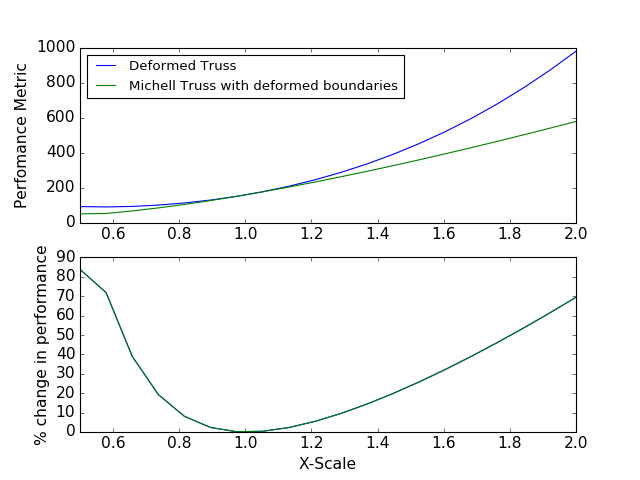

In [29]:
# Generate the structures
n_xscale = 20
s = np.linspace(0.5,2,n_xscale)

pm = np.zeros([n_xscale])
pm2 = np.zeros([n_xscale])
for i in range(len(s)):
    y_scale = 1/s[i]
    x_scale = s[i]#s[i]
    # Stretching the michell structure
    [f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,x_scale,y_scale)
    forces = simulate_truss(f)
    [pl,ax_f] = calculate_metric(forces, p, N1, N2)
    pm[i] = pl
    # VS
    # Generating a michell structure based on stretched boundary conditions
    [f, p, N1, N2] = setup_frame3dd_simulation(5,16*y_scale,40*x_scale,1.0,1.0)
    forces = simulate_truss(f)
    [pl,ax_f] = calculate_metric(forces, p, N1, N2)
    pm2[i] = pl
    
# Plot the results
plt.close('all')
f,axarr = plt.subplots(2,1)
axarr[0].plot(s,pm)
axarr[0].plot(s,pm2)
axarr[0].legend(['Deformed Truss','Michell Truss with deformed boundaries'],
               fontsize=12,loc=2)

axarr[1].plot(s,(((pm-pm2)/pm2)*100))

# pm = np.zeros([n_xscale])
# pm2 = np.zeros([n_xscale])
# for i in range(len(s)):
#     y_scale = 1#1/s[i]
#     x_scale = s[i]#s[i]
#     # Stretching the michell structure
#     [f, p, N1, N2] = setup_frame3dd_simulation(5,16,40,x_scale,y_scale)
#     forces = simulate_truss(f)
#     [pl,ax_f] = calculate_metric(forces, p, N1, N2)
#     pm[i] = pl
#     # VS
#     # Generating a michell structure based on stretched boundary conditions
#     [f, p, N1, N2] = setup_frame3dd_simulation(5,16*y_scale,40*x_scale,1.0,1.0)
#     forces = simulate_truss(f)
#     [pl,ax_f] = calculate_metric(forces, p, N1, N2)
#     pm2[i] = pl
    

axarr[1].plot(s,(((pm-pm2)/pm2)*100))


axarr[1].set_xlabel('X-Scale')
axarr[1].set_ylabel('% change in performance')
axarr[0].set_ylabel('Perfomance Metric')
axarr[0].set_xlim([0.5,2.0])
axarr[1].set_xlim([0.5,2.0])

plt.show()

Here, I'm plotting a cross section of the surface that is orthogonal to the plane x_scale = y_scale.

This shows the relative performance of the structure as it varies from squished on the left (with xs=0.5, ys=2.0) to stretched on the right (with xs=2.0, ys=0.5)

<h3>Conclusion</h3>

So... A design firm wanting to deform the standard Michell truss form will certainly need to run a more careful analysis of their specific geometry since it will surely perform worse than the standard Michell truss (normalized by volume).